In [54]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# (a) Dataset Exploration

Clustering is an unsupervised learning algorithm that seperates data (in this case, based on mean) and assigns each sample to a cluster. These clusters can then be taken to an expert in the field that can assign labels or use them for other purposes. The key idea however, is that the model has no information on what a cluster means, it simply assings it based on the sum of squared difference between a datapoint and the mean centroid of the cluster. This is the reasoning behind choosing a dataset such as this one, Parkinson's disease has 5 commonly accepted stages, with each stage showing different symptoms. The goal is to perform a clustering algorithm that can divide these 5 states given the features of the UCI Parkinsons dataset. 

We start by inspecting the shape of the dataset, this dataset has 5875 samples and 22 features. Importantly, the status of the patient is not a dependent label in this dataset, since this is being used for an unsupervised learning task. In the same vein, the subject# serves no purpose to our model in order to learn the clusters and therefore it is dropped. We confirm that there are no missing values that need to be taken care of, however in the case that there were- linear interpolation is the method of choice since all of the columns in this dataset are numeric. 

We then move on to preprocessing the dataset for a clustering algorithm

In [55]:
df_raw = pd.read_csv("/Users/parshvamehta/ece539-final/data/parkinsons-dataset/parkinsons_updrs.data")

df = df_raw.copy()
df.head()

n_samples, n_features = df.shape

df.drop(["subject#"], axis=1, inplace=True)


print(f"Number of samples (rows):    {n_samples}")
print(f"Number of raw features (cols): {n_features}")
print("\nFirst 5 rows:")
display(df.head())

print("\nData types:")
print(df.dtypes.to_frame("dtype"))

has_nan = df.isna().any().any()
print(f"Missing values: {has_nan}")

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nNumber of numeric variables: {len(num_cols)}")
print(f"Number of categorical variables:  {len(cat_cols)}")


Number of samples (rows):    5875
Number of raw features (cols): 22

First 5 rows:


,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361



Data types:
                 dtype
age              int64
sex              int64
test_time      float64
motor_UPDRS    float64
total_UPDRS    float64
Jitter(%)      float64
Jitter(Abs)    float64
Jitter:RAP     float64
Jitter:PPQ5    float64
Jitter:DDP     float64
Shimmer        float64
Shimmer(dB)    float64
Shimmer:APQ3   float64
Shimmer:APQ5   float64
Shimmer:APQ11  float64
Shimmer:DDA    float64
NHR            float64
HNR            float64
RPDE           float64
DFA            float64
PPE            float64
Missing values: False

Number of numeric variables: 21
Number of categorical variables:  0


# (b) Data Pre-processing and (c) Feature Extraction

Standard Scaling procedure is used since the measurements of these features differ in many orders of magnitude. There are also many features that are different measurements of the same symptom. My initial thought was to drop these highly correlated values, however I decided to use PCA to perform dimensionality reduction instead to preserve the potential interdependencies of the columns. I used a PCA variance of 0.95 which reduced the dimensionality of the dataset to 9. This means that the correlation and potential bias of the highly correlated features has been squashed into a PCA dimension. The combination of jitter and shimmer is likely that large PCA dimension 1 that can be seen in the graph.

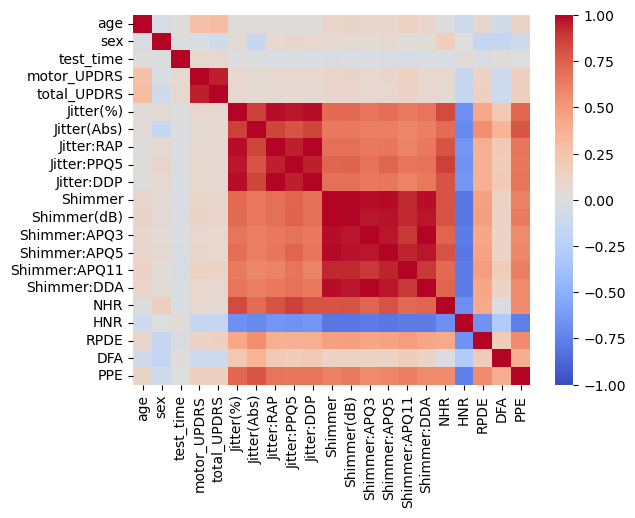

Text(0.5, 1.0, 'Principal Components with 95% data variance')

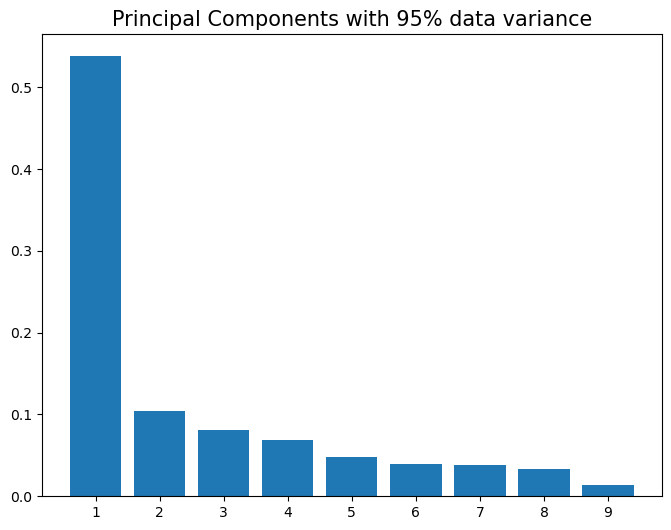

In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
corr = df.corr(method='pearson')

sns.heatmap(
    corr,
    cmap='coolwarm',
    vmin=-1, vmax=1,
)
plt.show()


pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.bar(x=[str(i) for i in range(1, pca.n_components_ + 1)], height=pca.explained_variance_ratio_)
plt.title('Principal Components with 95% data variance', size=15)

# (d) Machine Learning Classifier 1 - K-Means Clustering

We learned two methods of clustering in class this semester, K-means and K-mediods. K-means is the one thats easier to compute but performs suboptimally with outliers present. K-medioids is slightly better in terms of that. I did some initial scanning on DBSCAN and Hierarchical clustering, those may fit the problem at hand better however the two implemented in this notebook are the ones learned in class. 

- K-means initializes n_clusters amount of clusters and calculates the mean for each of them. Each point from the dataset after is compared to the mean of all clusters and assigned to the cluster that minimizes the sum of squared distance to the mean. This leads to overfitting as K increases (since at that point, every individual point will be assigned to its own cluster), while a lower value of K will fail to find any meaningful clustering. The method to decide the optimal k-value is by the elbow method, which plots K on the x axis and the sum of squared distances (inertia) on the y axis. The inertia will follow the trend of quickly decreasing as k goes from 1 to 4 or 5 and then gradually decrease after that. The point at which the gradual decent begins or the tip of the "elbow" is the optimal value for k. In the plot below, the optimal value seems to be aroun 4 or 5, however while researching the dataset, I found that parkinsons has 5 well known stages. Therefore, this elbow method was more of a check rather than a method to choose k. For this algorithm and K-medioids, I set k=5 to cluster the 5 stages of parkinsons. 
- Another parameter was max_iter which is the maximum number of iterations the model runs. The default from sklearn is 300, however I did not find any noticable difference raising this value all the way to 700. Some research lead me to this website (https://stats.stackexchange.com/questions/261836/k-means-how-many-iterations-in-practical-situations) which mentions that the K-means algorithm is cheap, and therefore we can run it for many iterations. This lead me to the conclusion that the default value is fine as is. 
- The next parameter in question is init, or the initialization method of clusters. The API documentation at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html mentions that the default value is k-means++ which is a greedy implementation of an algorithm (https://www.geeksforgeeks.org/machine-learning/ml-k-means-algorithm/) that samples based on an empirical probability distribution of the points contribution towards overall inertia. This method first randomly initailizes a first centriod. For the next centroids, the model first calculates the distance of each point to the nearest initialized center. It chooses a point with probability that goes up with the distance, making it more likely to choose a center far away. This speeds up convergence and has overall better cluster seperation. After all centers are chosen, the normal K-NN clustering algorithm proceeds. 
- Finally, there are two algorithms that the API outlines, LLoyd and elkan. Elkan is more efficient on datasets that have well defined clusters by using the triangle inequality. Comparing both algorithms yields almost identical results, espeically considering our choice of K=5, I chose to go with the default value (Lloyd).


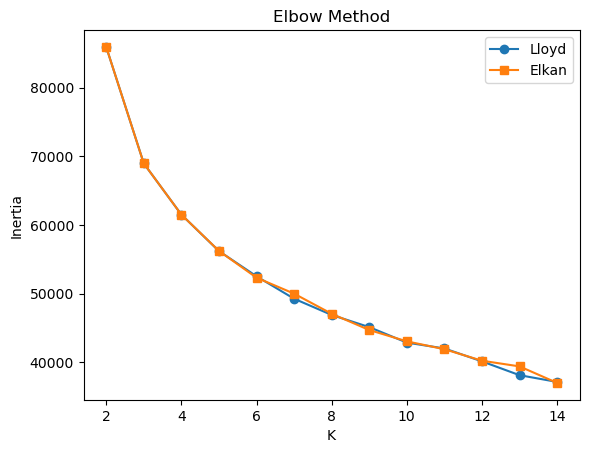

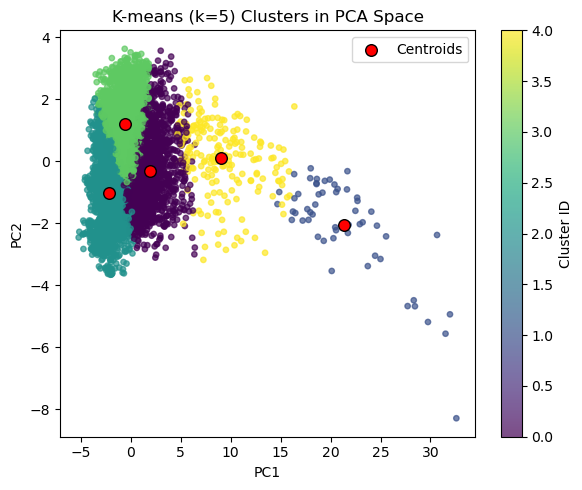

In [57]:
inertias = []
for k in range(2, 15):
    km = KMeans(n_clusters=k, algorithm="lloyd")
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(range(2,15), inertias, marker='o')
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("Elbow Method")

kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X_scaled)

inertias_E = []
for k in range(2, 15):
    km = KMeans(n_clusters=k, algorithm="elkan")
    km.fit(X_scaled)
    inertias_E.append(km.inertia_)

plt.plot(range(2,15), inertias_E, marker='s')

plt.legend(["Lloyd", "Elkan"], loc="best")

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=labels,
    s=15,
    alpha=0.7
)

centroids_scaled = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids_scaled)

plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    c="red",
    s=70,
    marker="o",
    edgecolors="black",
    linewidths=1,
    label="Centroids"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means (k=5) Clusters in PCA Space")
plt.colorbar(scatter, label="Cluster ID")
plt.legend()
plt.tight_layout()
plt.show()



# (d) Machine Learning Classifier 2 - DBSCAN

Denisty-Based Spatial Clustering of Applications with Noise is an unsupervised algorithm that groups datapoints based on denisty structure rather than distance to a particular centroid. This defines clusters as regions with points that have at least the minimum number of samples within a set vicinity. This allows it to identify randomly shaped clusters and label outliers as noise or insignificant. This differs from K-means clustering as DBSCAN does not need a certain number of clusters to be defined. (https://www.geeksforgeeks.org/machine-learning/dbscan-clustering-in-ml-density-based-clustering/)

While this is a good choice for exploratory data analysis or problems where there is clear seperation between clusters, this is not a good model for this dataset. This model works best for problems where the number of clusters is an open question or an anomaly detection problem. Under ideal seperation, this algorithm may have been a good way to find out how many stages of parkinsons there may be, and perhaps the 5 main ones could be subdivided, however what I failed to consider was the seperability of the symptoms between stages. Parkinsons disease is a disease that advances in a constant and often overlapping method (which was apparent to me after implementing K-means clustering).

The expected behavior for this algorithm on this particular dataset (going off the PCA visualization of K-means Clustering) is a large blob that encompasses the centroids towards the left side of the graph, with the right hand side of the graph being classified as an "outlier" cluster. This is in fact confirmed after running the code, however it also captures some points on the bottom left of the distribution that it likely detects as "anomalies"

It is difficult to correctly hypertune this model as it is so opposite to the problem statement at hand because parkinsons is a slow degenerative disease rather than one that has abrupt and acute symptom changes as the ailment progresses. These parameters are my attempt to bend this method towards the task at hand to the best of my ability. 
- eps: This is the maximum distance for a value to be considered in the same neighborhood. Setting this value to be low will decrease the number of clusters present, however the issue at hand is that these values are already very close to each other which puts them in the same cluster. I will raise this value to cause more seperation (till we get a good divide)
- min_samples: These are the minimun number of samples in an area to be considered a cluster. Setting this value to be high will force DBSCAN to find denser clusters. In our situation, we want the clusters to be dense and compact, but not overlapping. I think that raising this value while also raising eps might help by increasing seperation but also forcing the model to want dense close clusters. 
- metric: This algorithm uses euclidean distance.

Setting eps and min_samples to be too high (eps=4, min_samples=10) results in one cluster which gives us no valid information. However, finding the middle ground with (eps=2, min_samples=8) results in 5 clusters with a bit of similarity to the k-means clustering. This is by no means a good algorithm for this task, but some meaningful insight can come out of the tuned model. 

Untuned DBSCAN
Estimated number of clusters: 19
Number of noise points: 5748

Tuned DBSCAN
Estimated number of clusters: 5
Number of noise points: 381


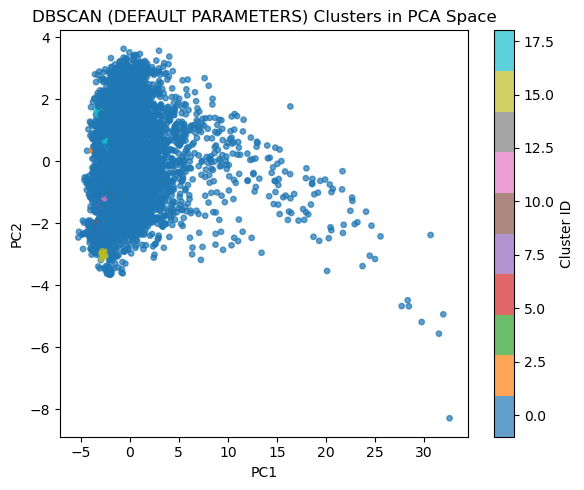

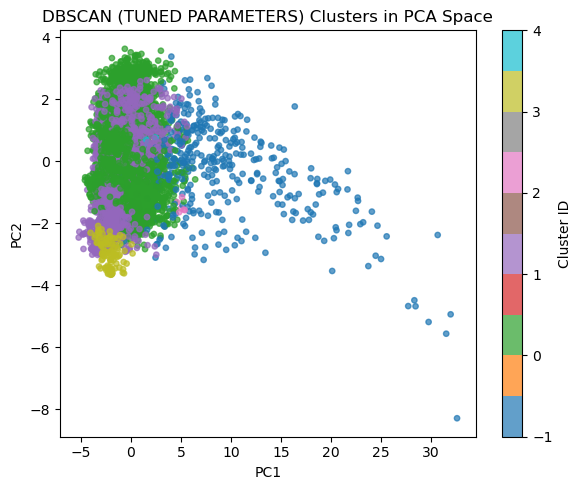

In [62]:
dbscan_default = DBSCAN(
    eps=0.6,  
    min_samples=5,
    metric="euclidean",
    n_jobs=-1
)
dbscan_tuned = DBSCAN(
    eps=2,  
    min_samples=8,
    metric="euclidean",
    n_jobs=-1
)


db_labels_default = dbscan_default.fit_predict(X_scaled)
db_labels_tuned = dbscan_tuned.fit_predict(X_scaled)

unique_labels = np.unique(db_labels)
n_clusters = len(unique_labels[unique_labels != -1])
n_noise = np.sum(db_labels == -1)

unique_labels_tuned = np.unique(db_labels_tuned)
n_clusters_tuned = len(unique_labels_tuned[unique_labels_tuned != -1])
n_noise_tuned = np.sum(db_labels_tuned == -1)


print("Untuned DBSCAN")
print(f"Estimated number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print("\nTuned DBSCAN")
print(f"Estimated number of clusters: {n_clusters_tuned}")
print(f"Number of noise points: {n_noise_tuned}")



plt.figure(figsize=(6, 5))

scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=db_labels_default,
    s=15,
    alpha=0.7,
    cmap="tab10"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("DBSCAN (DEFAULT PARAMETERS) Clusters in PCA Space")
plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))

scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=db_labels_tuned,
    s=15,
    alpha=0.7,
    cmap="tab10"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("DBSCAN (TUNED PARAMETERS) Clusters in PCA Space")
plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()


# (e) Comparison between K-Means Clustering and DBSCAN



All diagrams of Parkinsons Disease Stages (https://parkinsonsdisease.net/basics/stages) provide the same end result which is a slow progression into a high rate of deterioration in motor function. The K-means diagram plotted below follows that trend (in PCA dimensions). The first 3 clusters (teal, green, purple) are all very close and are interconnected. Although I do not have a degree in medicine, my guess is that these are the first three stages of Parkinsons, going from mild to moderate symptoms. Stage 4 and 5 are the stages where deterioration increases drastically, as seen by the distance between the means of the first three clusters and the final two. This result leads me to believe that K-means clustering (and likely K-medians as well) is a good fit to learn the different stages of Parkinsons. 

DBSCAN initially was an awful model as it classified all three of the inital stages of Parkinsons as one massive stage, however after tuning the hyperparameters- we get a model that is somewhat similar to the K-means model. As discussed in the previous section on DBSCAN, this model is not the right choice for the task I had set for the dataset due to the fact that I did not consider the smooth, indistinguishable boundries between stages 1-3 of Parkinsons. 

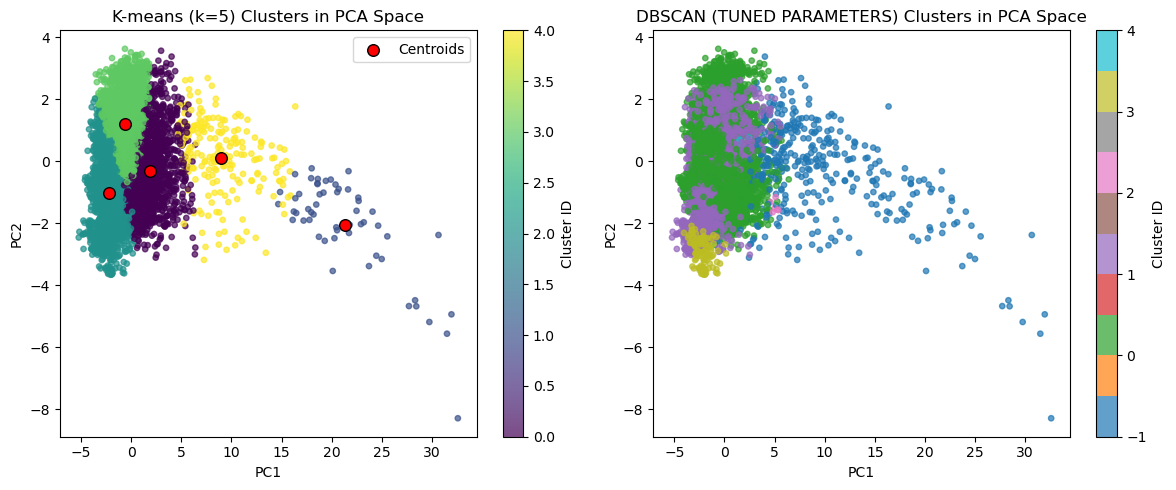

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# K-means plot
scatter = axes[0].scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=labels,
    s=15,
    alpha=0.7
)
axes[0].scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    c="red",
    s=70,
    marker="o",
    edgecolors="black",
    linewidths=1,
    label="Centroids"
)
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].set_title("K-means (k=5) Clusters in PCA Space")
axes[0].legend()
fig.colorbar(scatter, ax=axes[0], label="Cluster ID")

# DBSCAN plot
scatter = axes[1].scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=db_labels_tuned,
    s=15,
    alpha=0.7,
    cmap="tab10"
)
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].set_title("DBSCAN (TUNED PARAMETERS) Clusters in PCA Space")
fig.colorbar(scatter, ax=axes[1], label="Cluster ID")

plt.tight_layout()
plt.show()

# (f) Ethical Concerns

The ethical concerns of this dataset allign with the Retinal Dataset quite well. The main concern is the consent of the patient and their family as well as the ethics behind how this data is aquired. The sampling of this data must be done in a fashion that avoids racial, sexual or economical bias. Such biased samplings can lead to misinformation spreading. The dataset must also be anonymous, avoiding any identifiable personal information being leaked. 

# (g) References

- http://parkinsonsdisease.net/basics/stages 
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
- https://www.geeksforgeeks.org/machine-learning/dbscan-clustering-in-ml-density-based-clustering/
- https://stats.stackexchange.com/questions/261836/k-means-how-many-iterations-in-practical-situations
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html 
- https://www.geeksforgeeks.org/machine-learning/ml-k-means-algorithm/
- https://archive.ics.uci.edu/dataset/174/parkinsons